In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

C:\Users\Sebastian\Anaconda3plus\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


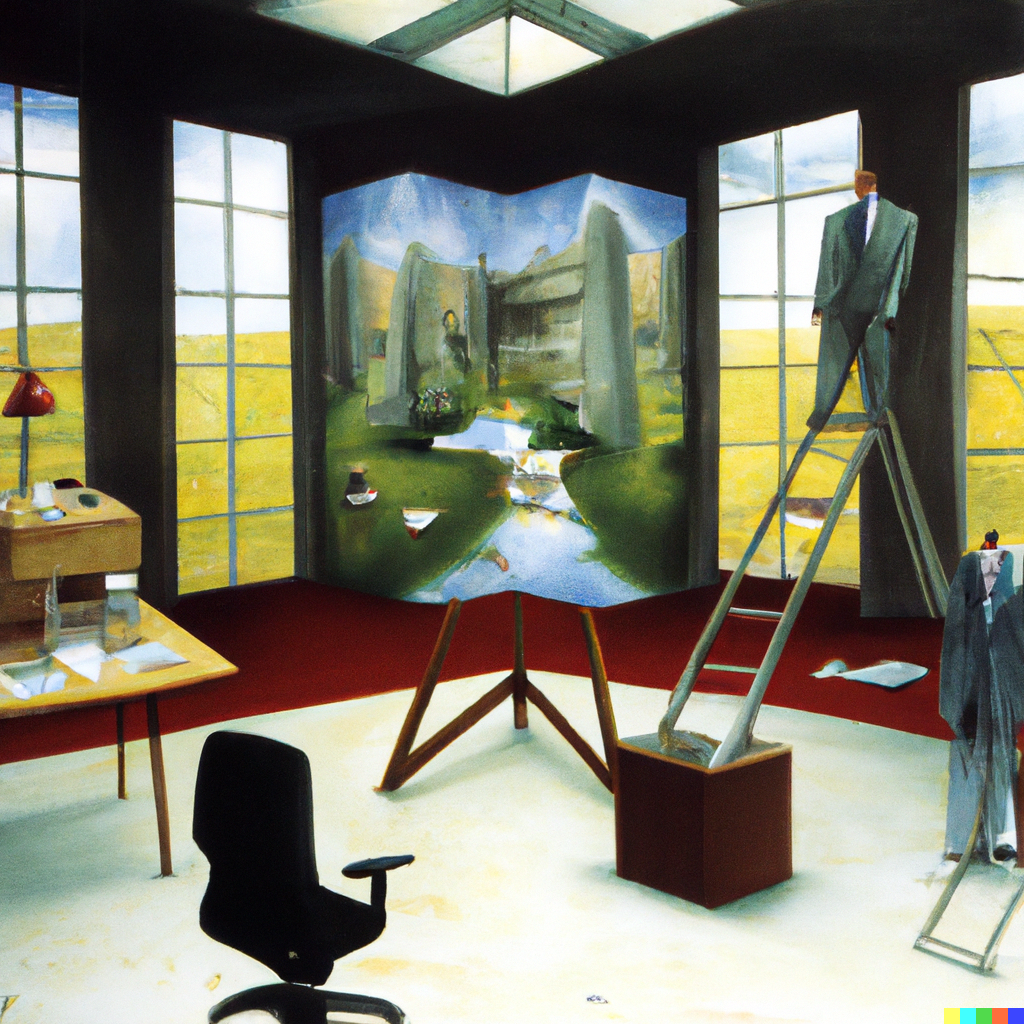

Hello, this notebook will deal with testing a categorical or discrete sequence for sequential independence. Usually, for independence / association tests and variables with discrete levels or categories, we use a Chi-squared or G Test, to test if a sample indicates an association between one categorical variable or another. A table is typically made, with one axis, the rows, representing one variable's cell totals for each level, and another axis, the columns, representing the levels of another variable. For example, if we wanted to test out if gender is independent of some categorical outcome, for example, the outcome of some disease or some medical procedure, we would use the Chi-squared Test for Association. 

This test relies on a iid (independent and identically distributed) sample from our population. But what if we wanted to test out if some sequence is or isn't sequentially independent ? For example, a supermarket partitions their store into 5 different locations:

1. Produce
2. Pharmacy
3. Deli
4. Groceries
5. Alcohol

And we want to test if, once a customer is inside the store / at the point of sale, their movements between locations are sequentially independent according to some marginal distribution, or if they tend to start at a section, then move to another section, and so on. We could also think of a website and their sitemap, and observe how a client moves through the site, through the products, and then to checkout, and see how sequentially independent this is. As we integrate location data and more stores and sites have these tracking capabilities, it presents an interesting opportunity for both experimentation and testing.

In this Notebook, I compare the Chi-Squared / G-Test for Association / Independence to a Likelihood Ratio Test that uses a Markov Model to gather information about the degree of sequential independence, if there is any. So, with any statistical test, we need a null hypothesis, a population that we want to sample from, and an alpha level:

In [3]:
A = np.tile([.6,.4],2).reshape((2,2))
A

array([[0.6, 0.4],
       [0.6, 0.4]])

Consider a discrete variable with values 0 and 1. Our null hypothesis is that the random variable is 0 60% of the time and is equal to 1 the remaining 40% of the time. And we have the following sequence: 

In [4]:
x = np.array([0,0,1,1,1,1,0,0,1,0,0,0,0,0])
len(x)

14

This sequence has slightly more 0s than 1s, and doesn't look far off from the null hypothesis just by looking at the cell totals. However, if we look at the breakdown for previous state (rows) and current state (columns) as a contingency table, we get:

In [5]:
#sample matrix constructor
def observation_matrix(A,x):
    m = len(x)-1
    c = A.shape[0]
    O = np.zeros((c,c))
    for t in range(m):
        for i in range(c):
            if x[t] == i:
                for j in range(c):
                    if x[t+1] == j:
                        O[i,j] += 1
    return O
#get the cell totals for the sample:
O = observation_matrix(A,x)
print(O)

[[6. 2.]
 [2. 3.]]


So there are 6 times where we have a 0, followed by a 0, 2 cases where we have a 0 followed by a 1, and so on. The total sum of all of the cell entries in this matrix is 13, which is one less than 14, because we are counting the transitions between states in our sample. So to conduct a Chi-Squared Test for Association, we first choose a confidence level ($\alpha = .05$) and construct the table of expected cell counts under $H_0$:

In [10]:
rowtot = O.sum(axis=1)
coltot = O.sum(axis=0)
E = np.outer(rowtot,coltot)/np.sum(O)
print(E)

[[4.92307692 3.07692308]
 [3.07692308 1.92307692]]


So now, we compute the degrees of freedom and the critical value for the test, both of which are based on the distribution of the test statistic under $H_0$:

In [11]:
alpha = .05
df = (A.shape[0] - 1)*(A.shape[1] - 1)
crit_val = ss.chi2(df).ppf(1-alpha)
crit_val

3.841458820694124

...and compute the test statistic- let's use the G Statistic instead of the usual Chi-Squared Statistic, which is itself an approximation of the G-Statistic:

In [13]:
G = 2*np.sum(O*np.log(O/E))
print(G)

1.5957605187880777


So we do not have enough evidence to indicate that the sequence is sequentially independent using the Chi Squared Test for Association. Also, we can compute a p-value:

In [14]:
p = 1-ss.chi2(df).cdf(G)
print(p)

0.20650504325602836


At a 5% alpha level, we don't have enough evidence to reject $H_0$. Ok, so what about the Markov Chain Based Test for Sequential Independence (Let's call it MCTSI) ? 

In [32]:
#sequential test statistic function
def sts(O,A,B):
    return -2*np.sum(O*np.log(A/B),where=(B>0))
B = O/np.tile(rowtot,A.shape[0]).reshape(A.shape).transpose()
print(B)

[[0.         0.8        0.2       ]
 [0.26666667 0.6        0.13333333]
 [0.         1.         0.        ]]


This is our estimate of the Transition Matrix based on the sample, and so the critical value and MTCSI are:

In [18]:
df = (A.shape[0])*(A.shape[0] - 1)
crit_val = ss.chi2(df).ppf(1-alpha)
print(crit_val)

5.991464547107979


In [19]:
ts = sts(O,A,B)
print(ts)

1.6086383150039048


So we would also not reject $H_0$ here, and our p-value is:

In [20]:
p = 1-ss.chi2(df).cdf(ts)
print(p)

0.44739242666666657


Ok, let's look at another example. Our null hypothesis and sample are:

In [22]:
A = np.tile([.4,.3,.3],3).reshape((3,3))
x = np.array([0,1,2,1,1,1,1,0,1,0,2,1,1,1,1,0,1,0,1,1,1,2,1,1])
print(A,len(x))

[[0.4 0.3 0.3]
 [0.4 0.3 0.3]
 [0.4 0.3 0.3]] 24


So let's choose an alpha level of $\alpha = .01$. This means that our degrees of freedom and test statistic for the Chi-Squared Test for Association are:

In [23]:
alpha = .01
df = (A.shape[0] - 1)*(A.shape[1] - 1)
crit_val = ss.chi2(df).ppf(1-alpha)
crit_val

13.276704135987622

Compute the test statistic:

In [27]:
O = observation_matrix(A,x)
rowtot = O.sum(axis=1)
coltot = O.sum(axis=0)
E = np.outer(rowtot,coltot)/np.sum(O)
G = 2*np.sum(O*np.log(O/E),where=(O>0))
print(G)

4.995321934902775


C:\Users\Sebastian\Anaconda3plus\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Sebastian\Anaconda3plus\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


So we do not reject $H_0$ since this test statistic is less than the critical value at a 1% alpha level. What about the p-value?

In [28]:
p = 1-ss.chi2(df).cdf(G)
print(p)

0.2877778307997476


Let's try the MTCSI at the sample alpha level, first by looking at the critical value and degrees of freedom:

In [30]:
B = O/np.tile(rowtot,A.shape[0]).reshape(A.shape).transpose()
df = (A.shape[0])*(A.shape[0] - 1)
crit_val = ss.chi2(df).ppf(1-alpha)
print(crit_val)

16.811893829770927


In [33]:
ts = sts(O,A,B)
print(ts)

20.248748154181484


C:\Users\Sebastian\Anaconda3plus\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Sebastian\Anaconda3plus\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
p = 1-ss.chi2(df).cdf(ts)
print(p)

0.0025006716904294457


So in this case, we would reject the claim to sequential independence and the marginal distribution specified in the null hypothesis. The p-value is below .01 and the test statistic is above the critical value, so we reject $H_0$. Ok, one last example, with $H_0$:

In [35]:
A = np.tile([.4,.4,.2],3).reshape((3,3))
x = np.array([0,0,1,2,0,1,1,0,1,1,0,0,0,2,1,0,0,1,1,0,0,1,0,1,2,0,1,1,0,0,2,1,0,2,1,0,0])
print(A,len(x))

[[0.4 0.4 0.2]
 [0.4 0.4 0.2]
 [0.4 0.4 0.2]] 37


Here's the Chi-Squared Test for Association Version of the test:

In [36]:
alpha = .01
df = (A.shape[0] - 1)*(A.shape[1] - 1)
crit_val = ss.chi2(df).ppf(1-alpha)
crit_val

13.276704135987622

In [37]:
O = observation_matrix(A,x)
rowtot = O.sum(axis=1)
coltot = O.sum(axis=0)
E = np.outer(rowtot,coltot)/np.sum(O)
G = 2*np.sum(O*np.log(O/E),where=(O>0))
print(G)

2.954316103762888


C:\Users\Sebastian\Anaconda3plus\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Sebastian\Anaconda3plus\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


In [38]:
p = 1-ss.chi2(df).cdf(G)
print(p)

0.5654993710514209


So we would not be able to reject $H_0$ even if there does appear to be some statistical dependence between consecutive terms in the sequence. For the MTCSI:

In [39]:
B = O/np.tile(rowtot,A.shape[0]).reshape(A.shape).transpose()
df = (A.shape[0])*(A.shape[0] - 1)
crit_val = ss.chi2(df).ppf(1-alpha)
print(crit_val)

16.811893829770927


In [40]:
ts = sts(O,A,B)
print(ts)

4.162595086941171


C:\Users\Sebastian\Anaconda3plus\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Sebastian\Anaconda3plus\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
p = 1-ss.chi2(df).cdf(ts)
print(p)

0.6546834375240309


Ok, so we wouldn't reject $H_0$ with this test statistic either. 